# TP Advanced Machine Learning : Part 2

We used **onyxia** virtual machines to speed up the calculations.

In [5]:
# !pip install torch
# !pip install torchvision
# !pip install ftfy regex tqdm
# !pip install git+https://github.com/openai/CLIP.git

# Question 1

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import clip
import torch.nn.functional as F
from tqdm import tqdm
device = 'cuda' if torch.cuda.is_available() else 'cpu'


model, clip_preprocess = clip.load("ViT-B/32", device=device)

model = model.to(device)

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=clip_preprocess)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=clip_preprocess)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# functions to show an image

100%|███████████████████████████████████████| 338M/338M [00:23<00:00, 15.0MiB/s]


99.1%

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


We create a first net that uses the clip model as a backbone. To do so, we use the ```encode_image``` method after loading the clip model with ```import clip```. As we found out the ```encode_image``` gives an tensor of dimension 512. We than apply to linear transformations to get the output size (=10). We first apply the ```gelu``` activation function as suggested.

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(512, 84)
        self.fc2 = nn.Linear(84, 10)

    def forward(self, x):
        x = model.encode_image(x).float()
        x = F.gelu(self.fc1(x))
        x = self.fc2(x)
        return x

We then create an instance of the net : 

In [8]:
net = Net()
net = net.to(device)

We then to use a **stochastic gradient descent** and an **entropy loss function**

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-4, momentum=0.9)


We define arrays to keep track of the results.

In [12]:
loss_in_time = []

We apply the usual loop for training the model :

In [13]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0

    for i, (inputs, labels) in enumerate(tqdm(trainloader, 0)):
        # load inputs to the GPU
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients this is important to do it at each batch since the gradient are accumulated
        optimizer.zero_grad()

        # forward - Graph is created
        outputs = net(inputs)

        # We compute the loss
        loss = criterion(outputs, labels)

        loss_in_time.append(loss.item())

        # backward - gradients of the the parameters of the model are computed
        loss.backward()

        # Gradient step on the parameters referenced in the optimizer
        optimizer.step()

        # print statistics
        running_loss += loss.item() * len(labels)

    # print every epoch
    print(f'Epoch {epoch:03}: train loss {running_loss / len(trainset):0.5}')
    running_loss = 0.0


100%|██████████| 782/782 [02:26<00:00,  5.35it/s]


Epoch 000: train loss 2.2531


100%|██████████| 782/782 [05:11<00:00,  2.51it/s]

Epoch 001: train loss 2.1154


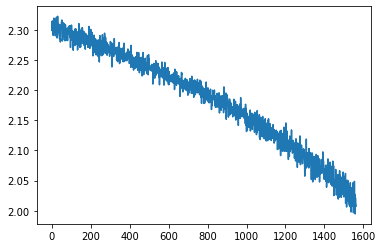

In [14]:
import matplotlib.pyplot as plt
plt.plot(loss_in_time[i for i in range(len)])

Then, we **test** the model : 

In [15]:
test_loss, correct = 0, 0
size = len(testloader.dataset)
with torch.no_grad():
    for i, (inputs, labels) in enumerate(tqdm(testloader, 0)):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        correct += (outputs.argmax(1) == labels).type(torch.float).sum().item()

test_loss /= 64
correct /= size
print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")



100%|██████████| 157/157 [00:25<00:00,  6.15it/s]

Test Error: 
 Accuracy: 78.1%, Avg loss: 4.950397 



# Question 2 :

We downloaded the hymenoptera file from the this link ```https://download.pytorch.org/tutorial/hymenoptera_data.zip```

As we could not download file bigger than 15 Mb, we use the request librairy to do so : 

In [23]:
import requests

url = 'https://download.pytorch.org/tutorial/hymenoptera_data.zip'
r = requests.get(url, allow_redirects=True)

open('hymenoptera_data.zip', 'wb').write(r.content)

47286322

We then unzip the result : 

In [24]:
from zipfile import ZipFile

with ZipFile('hymenoptera_data.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

We load the **train** and **val** datasets.

In [193]:
image_datasets = {x: torchvision.datasets.ImageFolder(os.path.join(os.getcwd(), 'hymenoptera_data', x), clip_preprocess) for x in ['train', 'val']}

We load the correspondind dataloaders.

In [194]:
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}

In [195]:
dataset_sizes = {x: len(image[x]) for x in ['train', 'val']} #{'train': 244, 'val': 153}

In [200]:
inputs = dataloaders['train']

In [201]:
inputs

In [202]:
# Prepare the inputs
# image, class_id = cifar100[3637]
image_input = inputs.to(device)
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in classes]).to(device)

AttributeError: 'DataLoader' object has no attribute 'to'

In [181]:
len(image_input) == len(text_inputs)

True

We use the clip model to get the enconding of both image and text

In [189]:
with torch.no_grad(): # We do not need to update the weigths
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)

In [190]:
# Pick the top 5 most similar labels for the image
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(2)

In [188]:

# Print the result
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{image.classes[index]:>16s}: {100 * value.item():.2f}%")


Top predictions:



AttributeError: 'dict' object has no attribute 'classes'

In [209]:
import os
import clip
import torch
from torchvision.datasets import CIFAR100

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

In [212]:
# Download the dataset
cifar100 = CIFAR100(root=os.path.expanduser("~/.cache"), download=True, train=False)
# C'est un torchvision.dataset de taille 10000
# Prepare the inputs
image, class_id = cifar100[3636]
print(image)
image_input = preprocess(image).unsqueeze(0).to(device)
print(len(image_input))
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in cifar100.classes]).to(device)
print(len(text_inputs))


Files already downloaded and verified
<PIL.Image.Image image mode=RGB size=32x32 at 0x7F5F5EA76F98>
1
100


In [ ]:
# Calculate features
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)

# Pick the top 5 most similar labels for the image
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(5)

# Print the result
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{cifar100.classes[index]:>16s}: {100 * value.item():.2f}%")